<a href="https://colab.research.google.com/github/Sidhtang/antici-pation-of-a-runner-s-injury-using-machine-learning/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'injury-prediction-for-competitive-runners:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1360225%2F2260133%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240518%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240518T180811Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D22239d3b8c0dbba3d2f1379d3dad54f168ecb7c01c13a41501d8f515bc263157f0199a95a66d7988641d593281c6abdea888696863957542ef14c5807b97f7a653963e611238a8be1dadb74554940273e2e61bc8083cdb89bbd187d0ef3a41c98f60c4f0a69a80b26bc8b75dc9c2858783dd2e4a6aa5d26333ddd06497ebe96aa185f85d81b36ac4a69eecd829b883acf117489de07239448efa2fad55f4112c853619ef7b2c3b8158026eecd670456e239918c6d336ea97a2746632c9d9fa0d05f9ecbe65e84dfb57af353e0a90029ca572bb69464debd62e433a544492ae12fe3e88a337aaa0ab6a065978db392bc1a2fdff62e06a41e0fbb49e72546ed1ed'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2609562 bytes downloaded
Downloaded and uncompressed: injury-prediction-for-competitive-runners
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/injury-prediction-for-competitive-runners/day_approach_maskedID_timeseries.csv
/kaggle/input/injury-prediction-for-competitive-runners/week_approach_maskedID_timeseries.csv


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [4]:
df = pd.read_csv("/kaggle/input/injury-prediction-for-competitive-runners/week_approach_maskedID_timeseries.csv")

In [5]:
df.head(10)

,nr. sessions,nr. rest days,total kms,max km one day,total km Z3-Z4-Z5-T1-T2,"nr. tough sessions (effort in Z5, T1 or T2)",nr. days with interval session,total km Z3-4,max km Z3-4 one day,total km Z5-T1-T2,...,max training success.2,avg recovery.2,min recovery.2,max recovery.2,Athlete ID,injury,rel total kms week 0_1,rel total kms week 0_2,rel total kms week 1_2,Date
0,5.0,2.0,22.2,16.4,11.8,1.0,2.0,10.0,10.0,0.6,...,0.0,0.18,0.16,0.20,0,0,0.718447,1.378882,1.919255,0
1,5.0,2.0,21.6,16.4,11.7,1.0,2.0,10.0,10.0,0.5,...,0.0,0.18,0.16,0.20,0,0,0.683544,1.018868,1.490566,1
2,5.0,2.0,21.6,16.4,11.7,1.0,2.0,10.0,10.0,0.5,...,0.0,0.17,0.16,0.18,0,0,0.683544,1.018868,1.490566,2
3,5.0,2.0,21.6,16.4,11.7,1.0,2.0,10.0,10.0,0.5,...,0.0,0.18,0.16,0.18,0,0,0.683544,1.018868,1.490566,3
4,6.0,1.0,39.2,17.6,18.9,1.0,3.0,17.2,10.0,0.5,...,0.0,0.17,0.16,0.18,0,0,2.202247,1.361111,0.618056,4
5,6.0,1.0,39.2,17.6,18.9,1.0,3.0,17.2,10.0,0.5,...,0.0,0.17,0.16,0.18,0,0,2.202247,1.361111,0.618056,5
6,6.0,1.0,33.3,17.6,15.4,1.0,3.0,13.7,7.2,0.5,...,0.0,0.17,0.16,0.18,0,0,1.500000,1.077670,0.718447,6
7,5.0,2.0,33.3,17.6,15.4,1.0,3.0,13.7,7.2,0.5,...,0.0,0.17,0.16,0.18,0,0,1.500000,1.077670,0.718447,7
8,5.0,2.0,32.9,17.6,15.5,0.0,3.0,14.3,7.2,0.0,...,0.0,0.17,0.16,0.18,0,0,1.523148,1.041139,0.683544,8
9,5.0,2.0,32.9,17.6,15.5,0.0,3.0,14.3,7.2,0.0,...,0.0,0.17,0.16,0.18,0,0,1.523148,1.041139,0.683544,9


In [6]:
df.describe()

,nr. sessions,nr. rest days,total kms,max km one day,total km Z3-Z4-Z5-T1-T2,"nr. tough sessions (effort in Z5, T1 or T2)",nr. days with interval session,total km Z3-4,max km Z3-4 one day,total km Z5-T1-T2,...,max training success.2,avg recovery.2,min recovery.2,max recovery.2,Athlete ID,injury,rel total kms week 0_1,rel total kms week 0_2,rel total kms week 1_2,Date
count,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,...,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,42798.000000,4.279800e+04,4.279800e+04,4.279800e+04,42798.000000
mean,5.809337,1.874667,49.543911,14.009255,9.433621,0.930184,1.672531,4.859398,3.456888,4.063970,...,0.525709,0.255089,0.184927,0.343522,34.538249,0.013435,4.408628e+05,9.014685e+05,4.803623e+05,1227.733422
std,2.484234,1.853287,36.715017,9.071678,8.887120,1.040631,1.263528,6.984670,4.577423,5.645305,...,0.390604,0.153214,0.127996,0.219536,19.020826,0.115130,4.328234e+06,6.945503e+06,4.656806e+06,806.495152
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,5.000000,1.000000,22.800000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.150000,0.110000,0.170000,20.000000,0.000000,6.955245e-01,6.723968e-01,6.923077e-01,437.000000
50%,6.000000,1.000000,44.800000,13.400000,8.000000,1.000000,2.000000,0.000000,0.000000,1.500000,...,0.730000,0.220000,0.160000,0.310000,34.000000,0.000000,9.891862e-01,1.001431e+00,9.897523e-01,1254.000000
75%,7.000000,3.000000,70.100000,18.300000,14.600000,2.000000,3.000000,8.000000,6.300000,6.300000,...,0.840000,0.360000,0.240000,0.520000,50.000000,0.000000,1.320515e+00,1.422171e+00,1.327586e+00,1913.000000
max,14.000000,7.000000,242.000000,131.000000,100.000000,6.000000,7.000000,79.800000,75.000000,80.000000,...,1.000000,0.900000,0.900000,1.000000,73.000000,1.000000,2.096000e+08,2.176000e+08,2.096000e+08,2673.000000


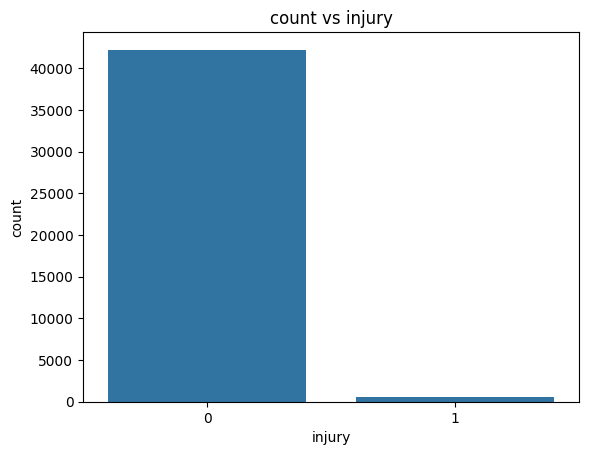

In [7]:
plt.title("count vs injury")
sns.countplot(x='injury', data = df)
plt.show()

In [9]:
df["Athlete ID"].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73])

In [11]:
dfc= df.copy()
dfc = dfc.set_index('Athlete ID')
dfc.head()

,nr. sessions,nr. rest days,total kms,max km one day,total km Z3-Z4-Z5-T1-T2,"nr. tough sessions (effort in Z5, T1 or T2)",nr. days with interval session,total km Z3-4,max km Z3-4 one day,total km Z5-T1-T2,...,min training success.2,max training success.2,avg recovery.2,min recovery.2,max recovery.2,injury,rel total kms week 0_1,rel total kms week 0_2,rel total kms week 1_2,Date
Athlete ID,,,,,,,,,,,,,,,,,,,,,
0,5.0,2.0,22.2,16.4,11.8,1.0,2.0,10.0,10.0,0.6,...,0.0,0.0,0.18,0.16,0.20,0,0.718447,1.378882,1.919255,0
0,5.0,2.0,21.6,16.4,11.7,1.0,2.0,10.0,10.0,0.5,...,0.0,0.0,0.18,0.16,0.20,0,0.683544,1.018868,1.490566,1
0,5.0,2.0,21.6,16.4,11.7,1.0,2.0,10.0,10.0,0.5,...,0.0,0.0,0.17,0.16,0.18,0,0.683544,1.018868,1.490566,2
0,5.0,2.0,21.6,16.4,11.7,1.0,2.0,10.0,10.0,0.5,...,0.0,0.0,0.18,0.16,0.18,0,0.683544,1.018868,1.490566,3
0,6.0,1.0,39.2,17.6,18.9,1.0,3.0,17.2,10.0,0.5,...,0.0,0.0,0.17,0.16,0.18,0,2.202247,1.361111,0.618056,4


In [12]:
dfc.shape

(42798, 71)

In [13]:
df1 = dfc[dfc['injury'] == 0]
df2 = dfc[dfc['injury'] == 1]

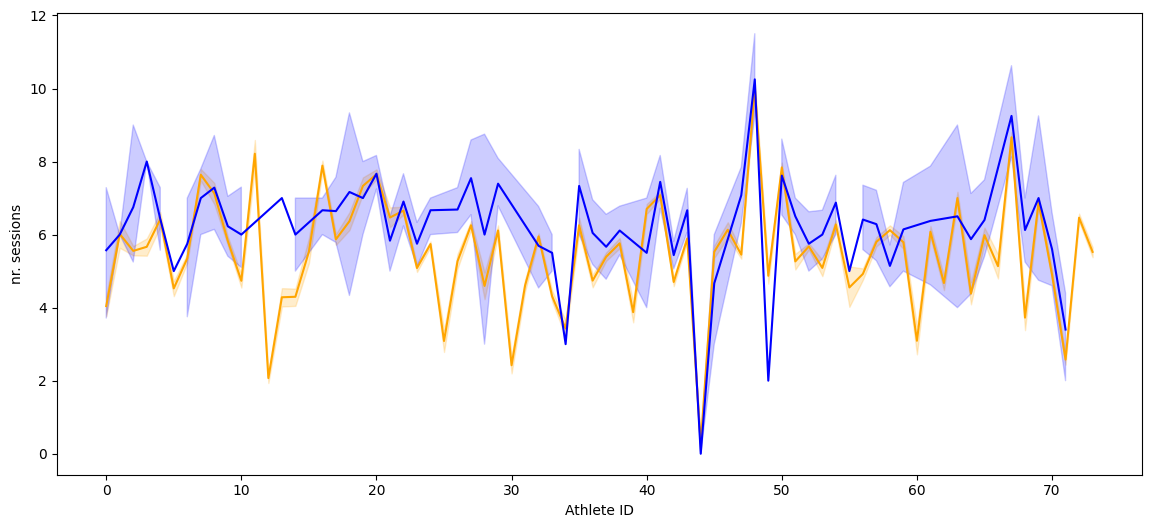

In [17]:
plt.figure(figsize=(14,6))
sns.lineplot(data=df1['nr. sessions'], color='orange')
sns.lineplot(data=df2['nr. sessions'], color='blue')
plt.show()

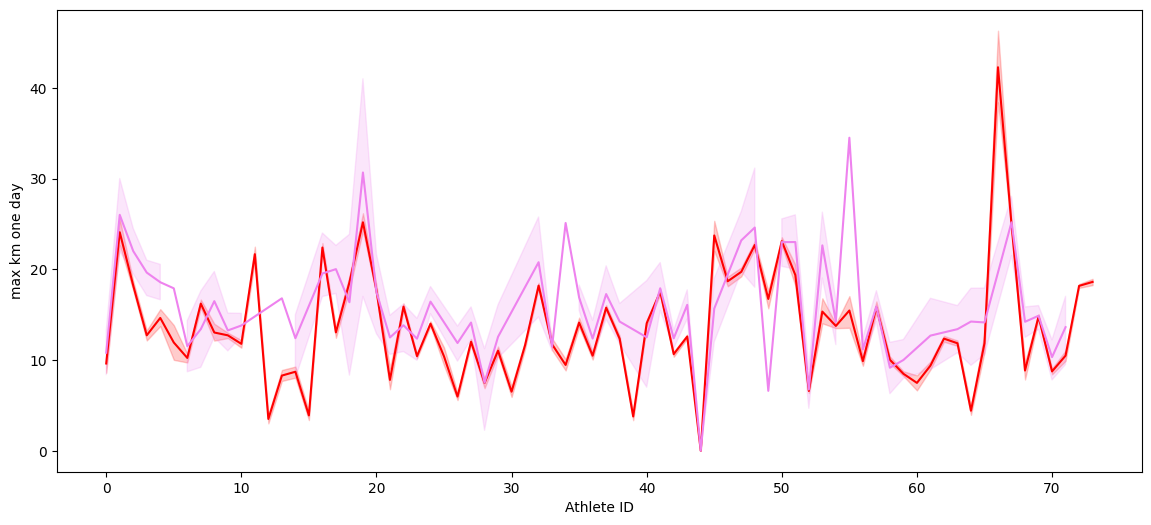

In [18]:
plt.figure(figsize=(14,6))
sns.lineplot(data=df1['max km one day'], color='red')
sns.lineplot(data=df2['max km one day'], color='violet')
plt.show()

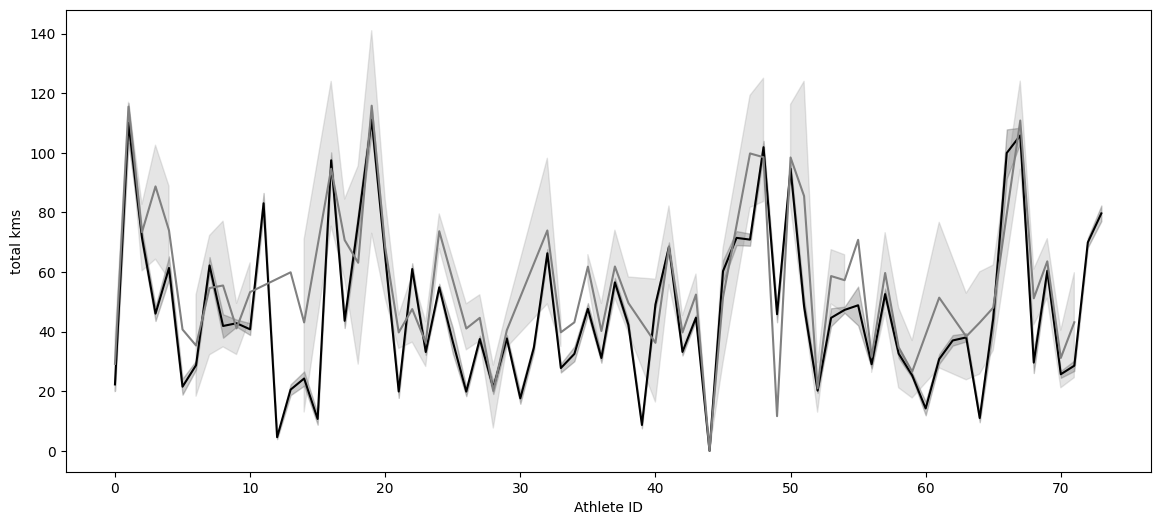

In [19]:
plt.figure(figsize=(14,6))
sns.lineplot(data=df1['total kms'], color='black')
sns.lineplot(data=df2['total kms'], color='grey')
plt.show()

In [20]:
y = dfc['injury']
x = dfc.drop('injury', axis=1)

In [21]:
x


,nr. sessions,nr. rest days,total kms,max km one day,total km Z3-Z4-Z5-T1-T2,"nr. tough sessions (effort in Z5, T1 or T2)",nr. days with interval session,total km Z3-4,max km Z3-4 one day,total km Z5-T1-T2,...,avg training success.2,min training success.2,max training success.2,avg recovery.2,min recovery.2,max recovery.2,rel total kms week 0_1,rel total kms week 0_2,rel total kms week 1_2,Date
Athlete ID,,,,,,,,,,,,,,,,,,,,,
0,5.0,2.0,22.2,16.4,11.8,1.0,2.0,10.0,10.0,0.6,...,0.00,0.00,0.00,0.18,0.16,0.20,0.718447,1.378882,1.919255,0
0,5.0,2.0,21.6,16.4,11.7,1.0,2.0,10.0,10.0,0.5,...,0.00,0.00,0.00,0.18,0.16,0.20,0.683544,1.018868,1.490566,1
0,5.0,2.0,21.6,16.4,11.7,1.0,2.0,10.0,10.0,0.5,...,0.00,0.00,0.00,0.17,0.16,0.18,0.683544,1.018868,1.490566,2
0,5.0,2.0,21.6,16.4,11.7,1.0,2.0,10.0,10.0,0.5,...,0.00,0.00,0.00,0.18,0.16,0.18,0.683544,1.018868,1.490566,3
0,6.0,1.0,39.2,17.6,18.9,1.0,3.0,17.2,10.0,0.5,...,0.00,0.00,0.00,0.17,0.16,0.18,2.202247,1.361111,0.618056,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,4.0,3.0,59.5,19.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.76,0.66,0.80,0.20,0.12,0.26,2.479167,1.101852,0.444444,2143
71,1.0,6.0,5.8,5.8,0.0,0.0,0.0,0.0,0.0,0.0,...,0.85,0.85,0.85,0.12,0.12,0.12,1.054545,1.288889,1.222222,2286
71,3.0,4.0,38.3,16.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.75,0.50,0.93,0.32,0.17,0.62,0.750980,0.743689,0.990291,2483


In [22]:
y


Athlete ID
0     0
0     0
0     0
0     0
0     0
     ..
71    1
71    1
71    1
71    1
71    1
Name: injury, Length: 42798, dtype: int64

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
#used random forest cause it was the one who was giving the highest accuracy .

In [26]:
from imblearn.over_sampling import SMOTE

X, y = SMOTE().fit_resample(x, y)

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

In [28]:
rf = RandomForestClassifier(n_estimators= 10, criterion="entropy")
rf.fit(X_train, Y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10)

In [29]:
y_pred_rf = rf.predict(X_test)
print(confusion_matrix(Y_test, y_pred_rf))

[[12559     5]
 [  172 12598]]


In [30]:
print(accuracy_score(Y_test, y_pred_rf))

0.9930133417541643


In [32]:
confm_rf = confusion_matrix(Y_test, y_pred_rf)

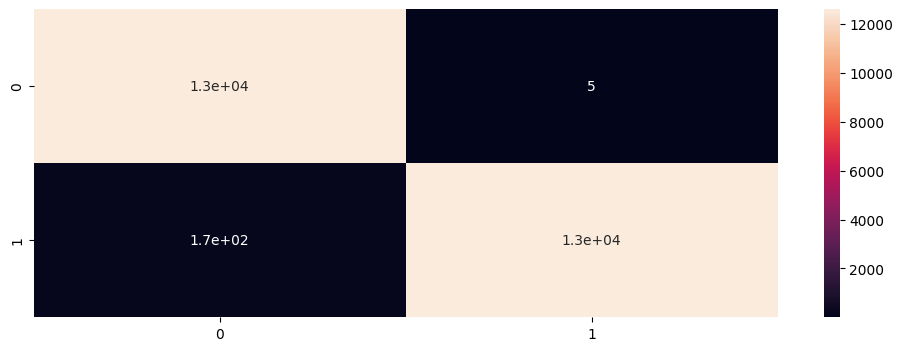

In [33]:
plt.figure(figsize=(12,4))
sns.heatmap(confm_rf, annot=True)
plt.show()